# Data Science Works on IMDB Data Set

Hey everyone, welcome to this notebook! You will see some data works here about this <code>IMDB Top 100 TV Series</code> data set. At the beginning, you see some data examination work. That's how we learn from data -also we can pick up on some patterns in the data.

So, let's start with importing all things we required for this project.

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import warnings
warnings.filterwarnings

print('All imports were successful!')

All imports were successful!


Let's continue with creating the data set variable.

In [2]:
df = pd.read_csv('/kaggle/input/imdb-top-1000-tv-series/data.csv')
df.head(10)

,id,title,genres,averageRating,numVotes,releaseYear
0,tt0903747,Breaking Bad,"Crime, Drama, Thriller",9.5,2238494,2008
1,tt5491994,Planet Earth II,Documentary,9.5,162347,2016
2,tt0185906,Band of Brothers,"Action, Drama, History",9.4,545959,2001
3,tt0795176,Planet Earth,"Documentary, Family",9.4,223867,2006
4,tt5152226,Tree of Life,Drama,9.4,13406,2014
5,tt7366338,Chernobyl,"Drama, History, Thriller",9.3,908333,2019
6,tt0306414,The Wire,"Crime, Drama, Thriller",9.3,391080,2002
7,tt0417299,Avatar: The Last Airbender,"Action, Adventure, Animation",9.3,390175,2005
8,tt30263074,Sapne Vs Everyone,Drama,9.3,71512,2023
9,tt6769208,Blue Planet II,Documentary,9.3,48924,2017


Let's gather some information from the data set.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   object 
 1   title          1000 non-null   object 
 2   genres         1000 non-null   object 
 3   averageRating  1000 non-null   float64
 4   numVotes       1000 non-null   int64  
 5   releaseYear    1000 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


As you can see here, we have 3 object and 3 numerical columns. For creating our machine learning model, we need numerical values -but we will do this later.

For data visualization, we can go with <code>titles, genres, and other numerical features</code>. But before, we gonna preprocess our data.

## Data Preprocessing

For our data works, it is the best time for doing some useful things. It is not necessary, but we will make <code>id</code> column integer. What we do here is:

1. Removing 'tt' from the beginning of the id.
2. Make it integer.

In [4]:
df['id'] = df['id'].str.replace('tt', '', regex=False)
df['id'].astype(int)
df.head(10)

,id,title,genres,averageRating,numVotes,releaseYear
0,0903747,Breaking Bad,"Crime, Drama, Thriller",9.5,2238494,2008
1,5491994,Planet Earth II,Documentary,9.5,162347,2016
2,0185906,Band of Brothers,"Action, Drama, History",9.4,545959,2001
3,0795176,Planet Earth,"Documentary, Family",9.4,223867,2006
4,5152226,Tree of Life,Drama,9.4,13406,2014
5,7366338,Chernobyl,"Drama, History, Thriller",9.3,908333,2019
6,0306414,The Wire,"Crime, Drama, Thriller",9.3,391080,2002
7,0417299,Avatar: The Last Airbender,"Action, Adventure, Animation",9.3,390175,2005
8,30263074,Sapne Vs Everyone,Drama,9.3,71512,2023
9,6769208,Blue Planet II,Documentary,9.3,48924,2017


So, drop the id column.

In [5]:
df.drop('id', axis=1, inplace=True)

Better now! We will not use that column, but maybe it helps for the future projects.

Let's continue with <code>genres</code> column. It has all variables together. We need to separate them, and make it numerical for our use. I show two different ways for it. One of them is <code>short and easy</code> and other one is <code>long and not as easy as the first one</code>.

Start with long one.

In [6]:
# Create another df variable for this part
df2 = df

# Start an empty dictionary
genre_list = {}

# Add genre names to the dictionary
for i, row in enumerate(df2['genres']):
    cells = row.split(', ')
    for j, cell in enumerate(cells):
        if cell in genre_list:
            continue
        else:
            genre_list[cell] = []

# Create a data frame for the purpose
df_genres = df2['genres'].str.split(', ', expand=True)
genre_list = pd.DataFrame(genre_list)

# Code with zeros and ones
for i, row in df_genres.iterrows():
    for j, cell in row.items():
        if pd.notna(cell):
            genre_list.loc[i, cell] = 1

# Create zeros
genre_list.replace(np.nan, 0, inplace=True)
genre_list = genre_list.astype(int)

# Merge data sets
df2 = pd.concat((df2, genre_list), axis=1)
df2.drop('genres', axis=1, inplace=True)

df2.head(10)

,title,averageRating,numVotes,releaseYear,Crime,Drama,Thriller,Documentary,Action,History,...,Reality-TV,Game-Show,Romance,Sci-Fi,Music,Sport,News,Talk-Show,Western,Musical
0,Breaking Bad,9.5,2238494,2008,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Planet Earth II,9.5,162347,2016,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Band of Brothers,9.4,545959,2001,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Planet Earth,9.4,223867,2006,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tree of Life,9.4,13406,2014,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Chernobyl,9.3,908333,2019,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,The Wire,9.3,391080,2002,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Avatar: The Last Airbender,9.3,390175,2005,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,Sapne Vs Everyone,9.3,71512,2023,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Blue Planet II,9.3,48924,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


You saw the long way for doing the same thing. Let's continue with the short one.

In [7]:
# Do the same thing with get_dummies()
df_genres = df['genres'].str.get_dummies(sep=', ')
df = pd.concat((df, df_genres), axis=1)
df.drop('genres', axis=1, inplace=True)

df.head(10)

,title,averageRating,numVotes,releaseYear,Action,Adventure,Animation,Biography,Comedy,Crime,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,Breaking Bad,9.5,2238494,2008,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,Planet Earth II,9.5,162347,2016,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Band of Brothers,9.4,545959,2001,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Planet Earth,9.4,223867,2006,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tree of Life,9.4,13406,2014,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Chernobyl,9.3,908333,2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,The Wire,9.3,391080,2002,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,Avatar: The Last Airbender,9.3,390175,2005,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Sapne Vs Everyone,9.3,71512,2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Blue Planet II,9.3,48924,2017,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check if there are any empty cells.

In [8]:
print(f'{df.isna().sum().sum()} empty cells has been found.')

0 empty cells has been found.


Great! There is no empty cell in the <code>df</code> variable right now. Let's continue with data visualization.

## Data Visualization

The time has come for gathering some insights from our data. We will review votes and ratings for series before 2000's and after 2000's.

We gonna review these ratings by their number of votes. Let's start with before 2000's.

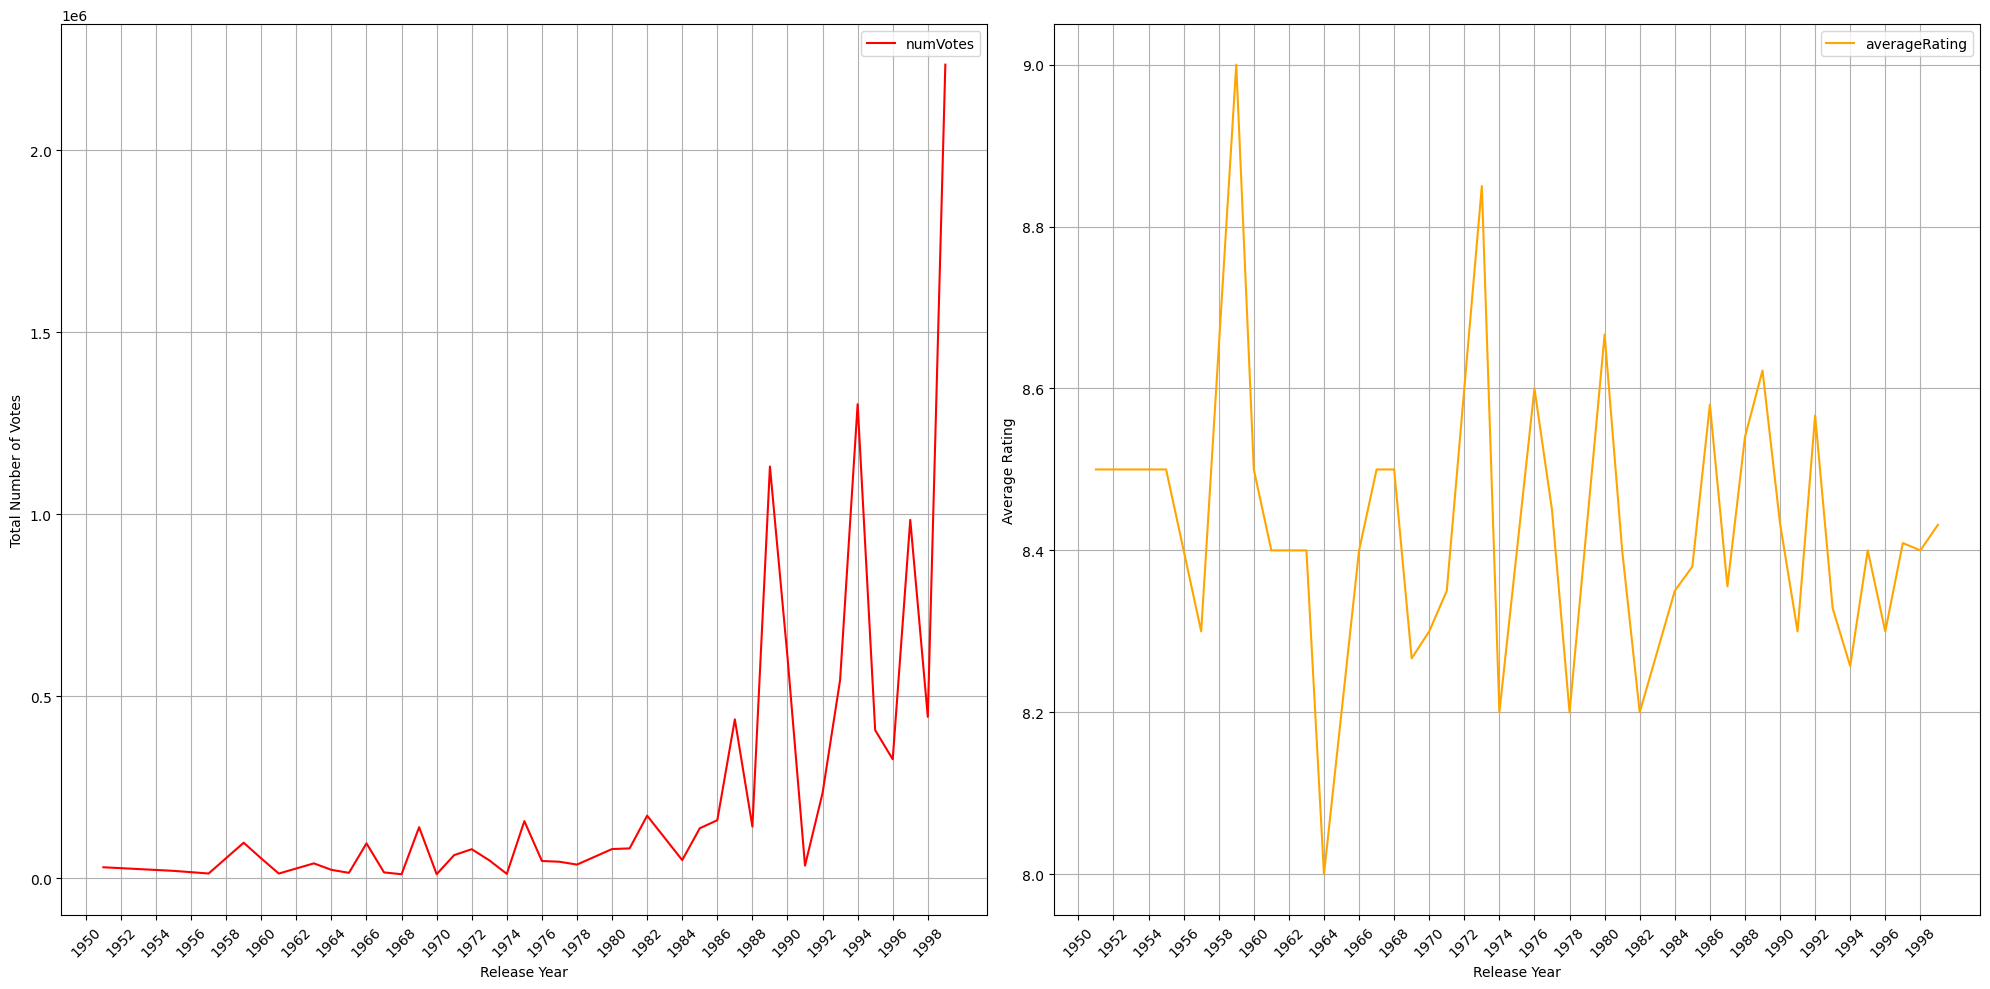

In [9]:
# Create a table for number of votes by year
before_2000s_numvotes = df[df['releaseYear'] < 2000][['releaseYear', 'numVotes']]
before_2000s_numvotes = before_2000s_numvotes.groupby(by='releaseYear', as_index=False).sum()

# Create a graph for number of votes by year
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
before_2000s_numvotes.plot(kind='line', x='releaseYear', y='numVotes', ax=axes[0], color='red')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Total Number of Votes')
axes[0].grid()
axes[0].set_xticks(range(1950, 1999, 2))
axes[0].set_xticklabels(range(1950, 1999, 2), rotation=45)

# Create a table for average ratings by year
before_2000s_avgratings = df[df['releaseYear'] < 2000][['releaseYear', 'averageRating']]
before_2000s_avgratings = before_2000s_avgratings.groupby(by='releaseYear', as_index=False).mean()

# Create a graph for average ratings by year
before_2000s_avgratings.plot(kind='line', x='releaseYear', y='averageRating', ax=axes[1], color='orange')
axes[1].set_xlabel('Release Year')
axes[1].set_ylabel('Average Rating')
axes[1].grid()
axes[1].set_xticks(range(1950, 1999, 2))
axes[1].set_xticklabels(range(1950, 1999, 2), rotation=45)

# Show the graph
plt.tight_layout()
plt.show()

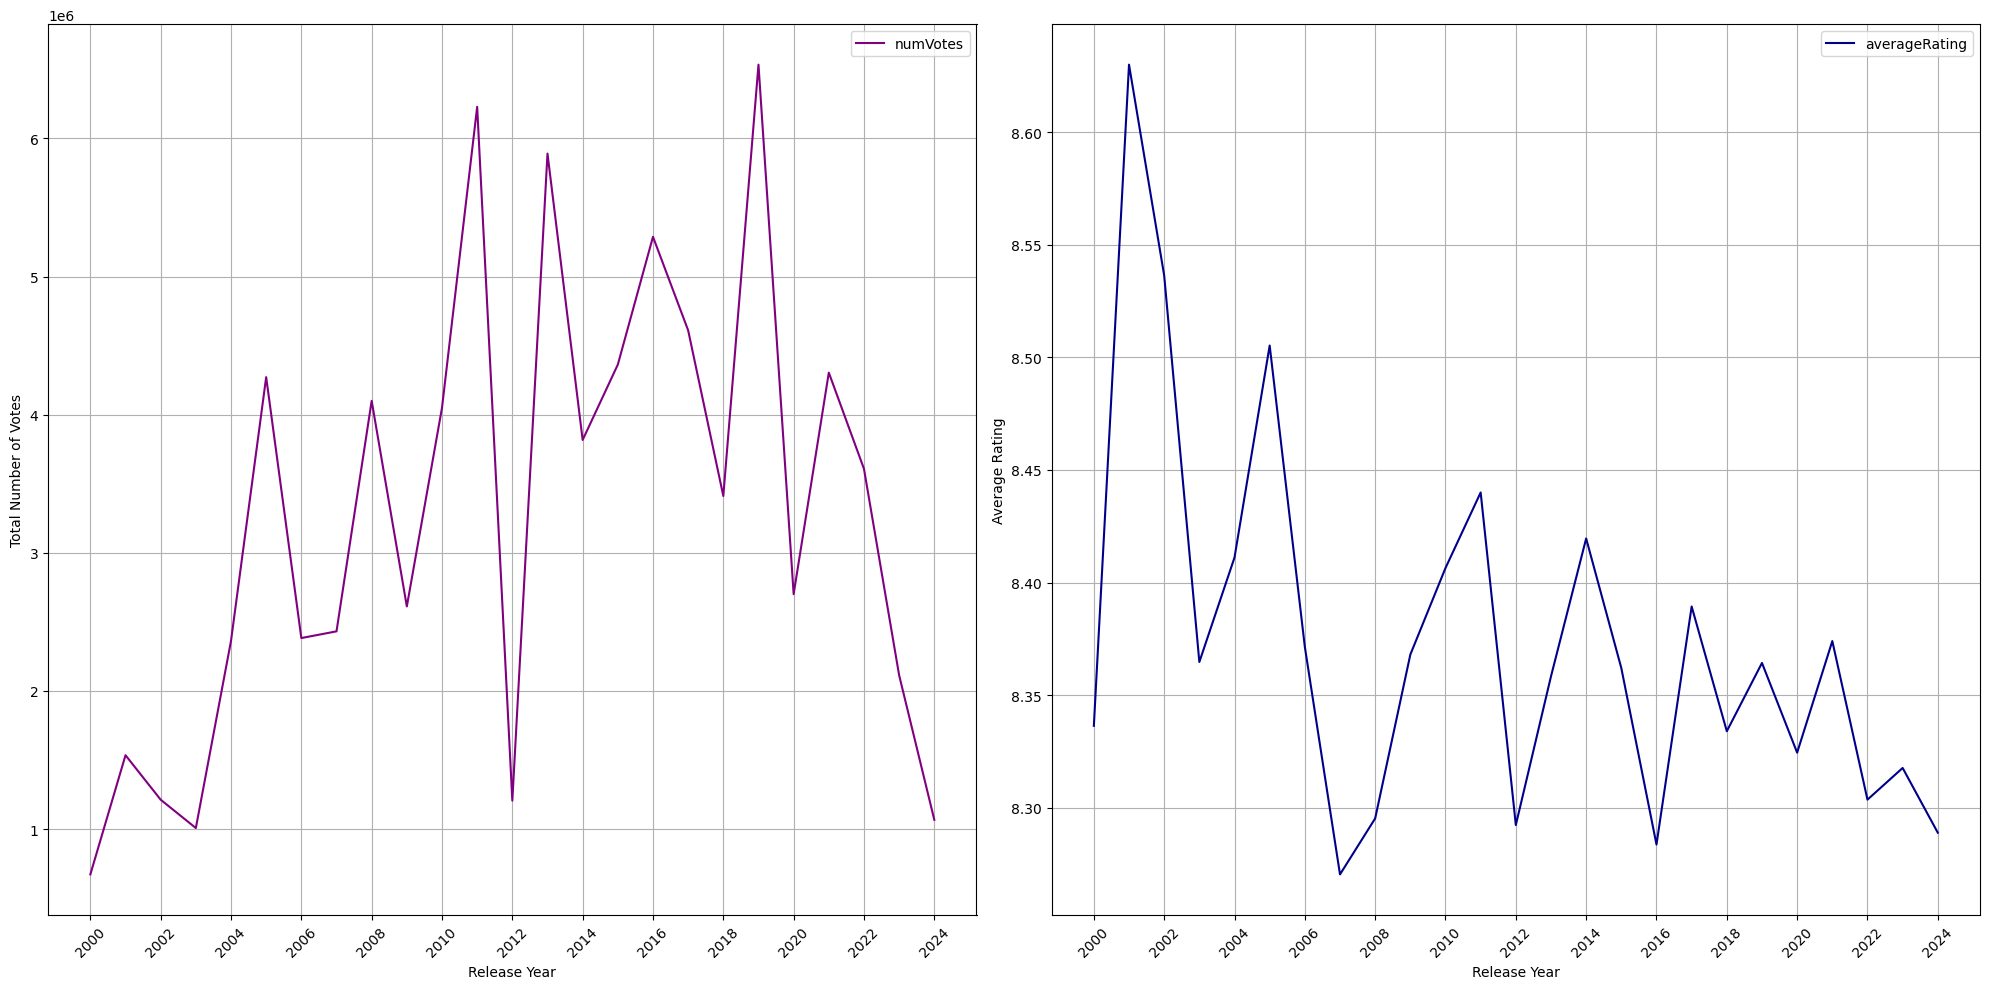

In [10]:
# Create a table for number of votes by year
after_2000s_numvotes = df[df['releaseYear'] >= 2000][['releaseYear', 'numVotes']]
after_2000s_numvotes = after_2000s_numvotes.groupby(by='releaseYear', as_index=False).sum()

# Create a graph for number of votes by year
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 
after_2000s_numvotes.plot(kind='line', x='releaseYear', y='numVotes', ax=axes[0], color='purple')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Total Number of Votes')
axes[0].grid()
axes[0].set_xticks(range(2000, 2025, 2))
axes[0].set_xticklabels(range(2000, 2025, 2), rotation=45)

# Create a table for average ratings by year
after_2000s_avgratings = df[df['releaseYear'] >= 2000][['releaseYear', 'averageRating']]
after_2000s_avgratings = after_2000s_avgratings.groupby(by='releaseYear', as_index=False).mean()

# Create a graph for average ratings by year
after_2000s_avgratings.plot(kind='line', x='releaseYear', y='averageRating', ax=axes[1], color='darkblue')
axes[1].set_xlabel('Release Year')
axes[1].set_ylabel('Average Rating')
axes[1].grid()
axes[1].set_xticks(range(2000, 2025, 2))
axes[1].set_xticklabels(range(2000, 2025, 2), rotation=45)

# Show the graph
plt.tight_layout()
plt.show()

As you can see from the graphs, before 2000s has less votes than after 2000s -because of the technology. Before 2000's everyone does not have access to the internet, so these numbers normally low. Let's do the comparement.

* After 2000s, you can see high voting numbers. Before 2000s, it is not like that.
* The highest average rating point of 1900s is 9.0. For 2000s, it is something around 8.6.
* The lowest average rating point of 1900s is 8.0. For 2000s, it is 8.25.
* While the ratings were generally around 8.5 before the 2000s, they showed a general decline after the 2000s until 2024, reaching their lowest value in 2024.
* But the lowest point of after 2000s is 0.25 point better than the lowest point of before 2000s.
* However, in general, fluctuating trends can be mentioned for each year. In general, average ratings are between 8.0 and 9.0 points.

So, that's it. Right now, we will create the graph of genres for before/after 2000s.

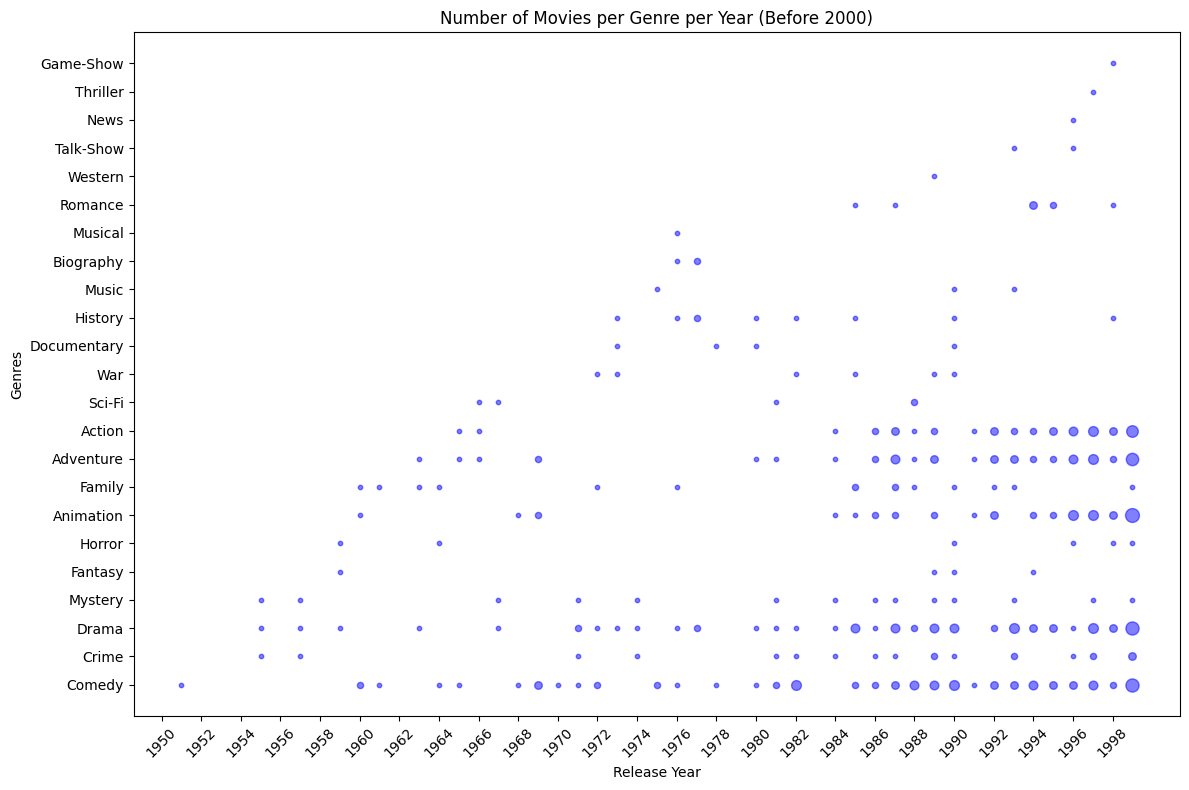

In [11]:
# Create the table
before_2000s_genres = df[df['releaseYear'] < 2000].drop(['title', 'averageRating', 'numVotes'], axis=1)
before_2000s_genres = before_2000s_genres.groupby(by='releaseYear').sum()

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Create dots for every year and genres
for year in before_2000s_genres.index:
    for genre in before_2000s_genres.columns:
        count = before_2000s_genres.loc[year, genre]
        if count > 0:
            ax.scatter(year, genre, s=count*10, color='blue', alpha=0.5)

# Graph settings
ax.set_xlabel('Release Year')
ax.set_ylabel('Genres')
ax.set_xticks(range(1950, 2000, 2))
ax.set_xticklabels(range(1950, 2000, 2), rotation=45)
plt.title('Number of Movies per Genre per Year (Before 2000)')
plt.tight_layout()
plt.show()

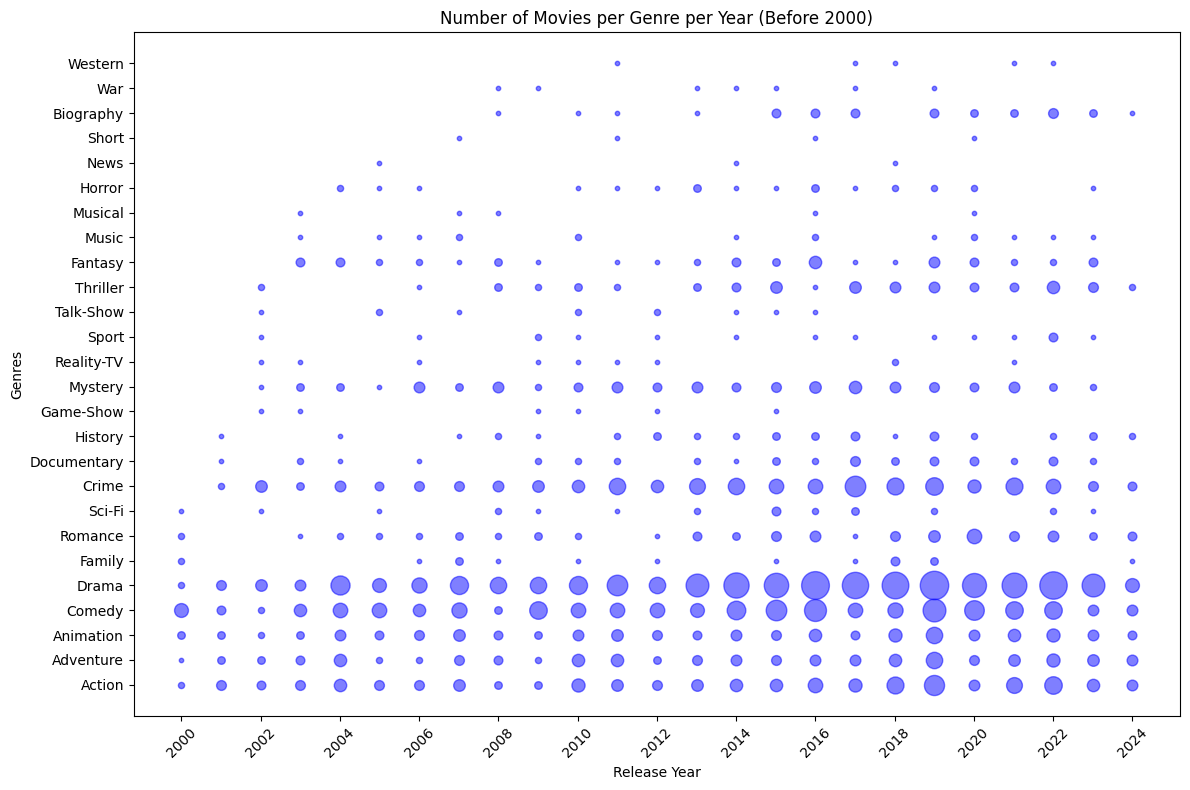

In [12]:
# Create the table
after_2000s_genres = df[df['releaseYear'] >= 2000].drop(['title', 'averageRating', 'numVotes'], axis=1)
after_2000s_genres = after_2000s_genres.groupby(by='releaseYear').sum()

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Create dots for every year and genres
for year in after_2000s_genres.index:
    for genre in after_2000s_genres.columns:
        count = after_2000s_genres.loc[year, genre]
        if count > 0:
            ax.scatter(year, genre, s=count*10, color='blue', alpha=0.5)

# Graph settings
ax.set_xlabel('Release Year')
ax.set_ylabel('Genres')
ax.set_xticks(range(2000, 2025, 2))
ax.set_xticklabels(range(2000, 2025, 2), rotation=45)
plt.title('Number of Movies per Genre per Year (Before 2000)')
plt.tight_layout()
plt.show()

You can barely see the weights of the film genres for the year. For example, comedy genre is one of the most important film genres before 2000s. But when we talk about after 2000s, drama genre is very important.

Also we can select the best and the least important film genres for these years.

In [13]:
before_2000s_genres.sum()

Action         41
Adventure      48
Animation      43
Biography       3
Comedy         78
Crime          20
Documentary     4
Drama          67
Family         15
Fantasy         4
Game-Show       1
History         9
Horror          6
Music           3
Musical         1
Mystery        14
News            1
Reality-TV      0
Romance         8
Sci-Fi          5
Short           0
Sport           0
Talk-Show       2
Thriller        1
War             6
Western         1
dtype: int64

In [14]:
after_2000s_genres.sum()

Action         196
Adventure      137
Animation      141
Biography       35
Comedy         307
Crime          221
Documentary     43
Drama          543
Family          19
Fantasy         56
Game-Show        6
History         39
Horror          23
Music           16
Musical          5
Mystery         95
News             3
Reality-TV      10
Romance         80
Sci-Fi          23
Short            4
Sport           17
Talk-Show       11
Thriller        70
War              7
Western          5
dtype: int64

We were right! Before 2000s, comedy genre is the most important one. And after 2000s drama is the most important one.

But if we talk about the least important ones; sport, reality-tv, short are the ones before 2000s. They are 0 series in their category. After 2000s, news series is the least important series genre with 3 series.

We have done with our data visualization part right now -we gathered some valuable insights. Let's continue with machine learning part.

## Machine Learning

At this part of the project, we will try to train a good machine learning model that aims to predict rating values. For this, we need to work with numerical columns. So let's start with dropping our object column.

In [15]:
df.drop(['title'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   averageRating  1000 non-null   float64
 1   numVotes       1000 non-null   int64  
 2   releaseYear    1000 non-null   int64  
 3   Action         1000 non-null   int64  
 4   Adventure      1000 non-null   int64  
 5   Animation      1000 non-null   int64  
 6   Biography      1000 non-null   int64  
 7   Comedy         1000 non-null   int64  
 8   Crime          1000 non-null   int64  
 9   Documentary    1000 non-null   int64  
 10  Drama          1000 non-null   int64  
 11  Family         1000 non-null   int64  
 12  Fantasy        1000 non-null   int64  
 13  Game-Show      1000 non-null   int64  
 14  History        1000 non-null   int64  
 15  Horror         1000 non-null   int64  
 16  Music          1000 non-null   int64  
 17  Musical        1000 non-null   int64  
 18  Mystery  

Wonderful! As you can see, there are only numerical-columns in our data set right now.

Right now, let's check for shape of the data set before training some machine learning models.

In [16]:
df.shape

(1000, 29)

We have 1000 rows and 29 columns. Wonderful! Let's check for the correlations of our data set before processing.

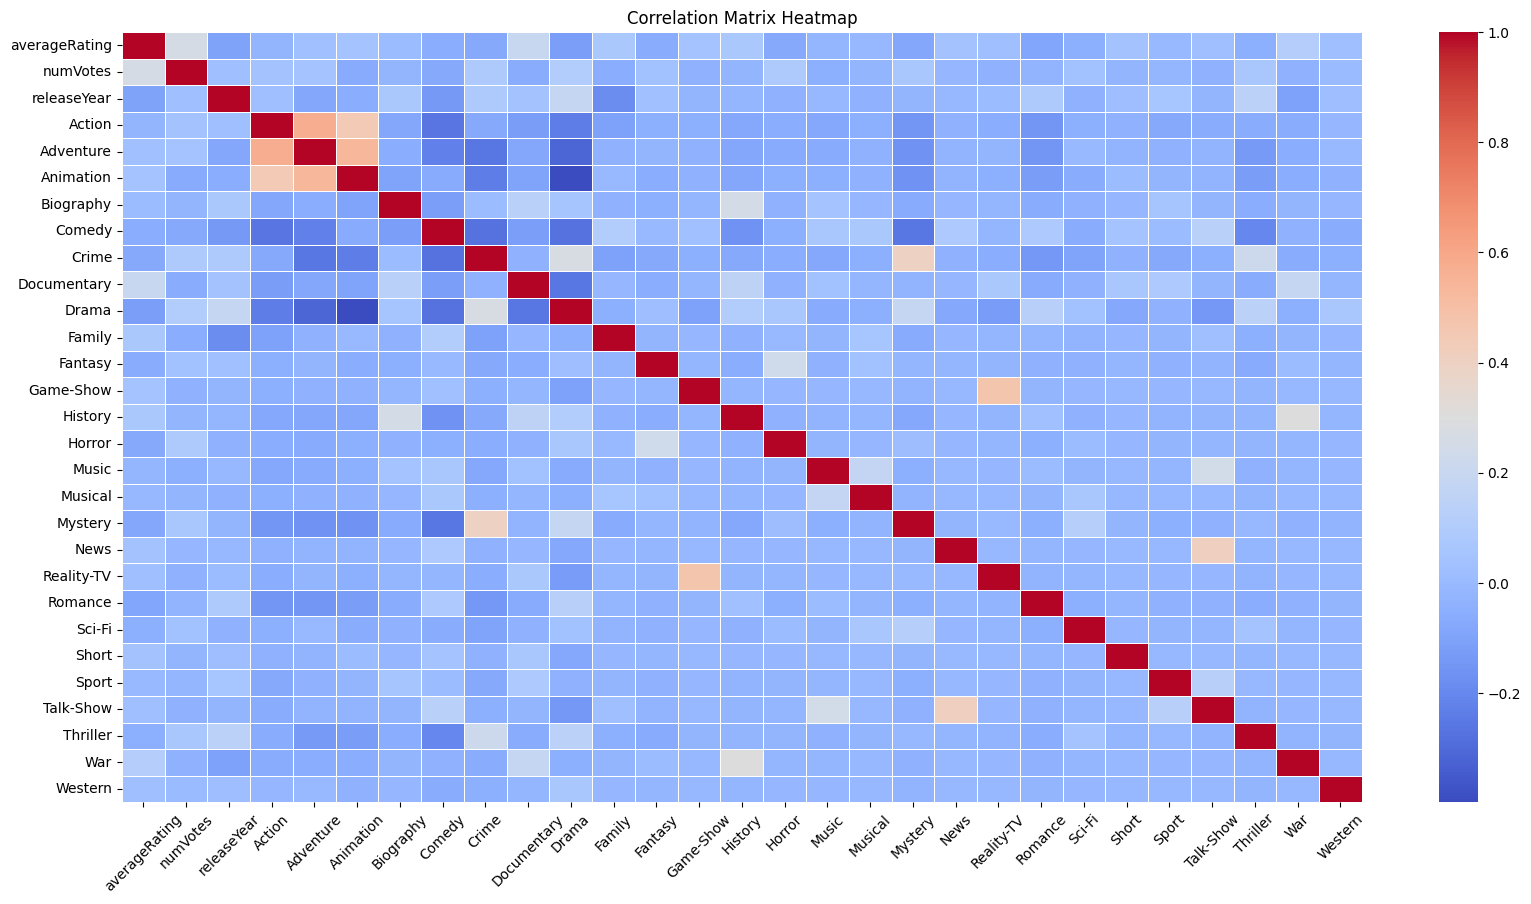

In [17]:
# Heatmap correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, linewidths=0.5)

# Graph settings
plt.xticks(rotation=45)
plt.title('Correlation Matrix Heatmap')
plt.show()

As you can see here, some of columns have good correlations with each other. It means that some of them have good relationship with each other, but some of them not.

In this project, we will train these models:

* Decision tree
* LightGBM
* Extra randomized trees
* RBF SVM

We will use classifying methods with different techniques. Let's start with creating <code>averageRatingClass</code> for classifying. After that, create variables and split them.

In [18]:
# Create classes of average ratings
df['averageRatingClass'] = pd.cut(
    df['averageRating'], 
    bins=[7.89, 8.3, 8.7, 9.1, 9.51],
    labels=[1, 2, 3, 4],
    right=False
)

# Create variables and split them
X = df.drop(['averageRating', 'averageRatingClass'], axis=1)
y = df['averageRatingClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

Train the decision tree classifier.

In [19]:
# Create parameters
params = {'criterion': ['gini', 'log_loss', 'entropy'],
          'max_depth': [None, 5, 10, 15, 20],
          'min_samples_split': [2, 4, 5, 7, 9],
          'min_samples_leaf': [1, 2, 4, 5, 6]}

# Train a GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)

In [20]:
# Train decision tree classifier
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = dtc.predict(X_test)

# Evaluate its performance
dtc_accuracy = accuracy_score(y_test, y_hat)
dtc_recall = recall_score(y_test, y_hat, average='weighted')
dtc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {dtc_accuracy}
Recall Score: {dtc_recall}
F1 Score: {dtc_f1}''')

Accuracy Score: 0.475
Recall Score: 0.475
F1 Score: 0.4465183151011742


As you can see here, decision tree classifier model was not successful -it did not get a result better than 50% accuracy. It will be base of some of our models, but we will continue to trying. If we continue to get accuracies less than 50%, we will change our strategy. For now, let's continue trying with training our Extra Randomized Trees model.

In [21]:
# Train an extra trees classifier and make predictions
etc = ExtraTreesClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = etc.predict(X_test)

# Evaluate the performance
etc_accuracy = accuracy_score(y_test, y_hat)
etc_recall = recall_score(y_test, y_hat, average='weighted')
etc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {etc_accuracy}
Recall Score: {etc_recall}
F1 Score: {etc_f1}''')

Accuracy Score: 0.475
Recall Score: 0.475
F1 Score: 0.4304007177033493


We have got approximately the same result with decision tress. Let's continue with LightGBM training and GridSearchCV for this model.

In [22]:
# Create parameters and train a GridSearchCV
params = {
    'num_leaves': [7, 15, 31],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, -1],
    'min_child_samples': [10, 20, 30]
}

grid = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=5).fit(X_train, y_train)

In [23]:
# Train a lightgbm and make predictions
lgb_model = lgb.LGBMClassifier(**grid.best_params_, verbose=-1).fit(X_train, y_train)
y_hat = lgb_model.predict(X_test)

# Evaluate the performance
lgb_accuracy = accuracy_score(y_test, y_hat)
lgb_recall = recall_score(y_test, y_hat, average='weighted')
lgb_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {lgb_accuracy}
Recall Score: {lgb_recall}
F1 Score: {lgb_f1}''')

Accuracy Score: 0.405
Recall Score: 0.405
F1 Score: 0.3803395322626092


We have got approximately the same result for LightGBM also. Let's continue with RBF and Polynomial SVM techniques.

In [24]:
# Create parameters and train a GridSearchCV
params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

grid = GridSearchCV(SVC(kernel='rbf'), params, cv=5).fit(X_train, y_train)

# Train a rbf svm and make predictions
rbf_svm = SVC(kernel='rbf', **grid.best_params_).fit(X_train, y_train)
y_hat = rbf_svm.predict(X_test)

# Evaluate the performance
rbf_accuracy = accuracy_score(y_test, y_hat)
rbf_recall = recall_score(y_test, y_hat, average='weighted')
rbf_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {rbf_accuracy}
Recall Score: {rbf_recall}
F1 Score: {rbf_f1}''')

Accuracy Score: 0.37
Recall Score: 0.37
F1 Score: 0.2776482213438735


Also our RBF SVM results seems not good. After this part, we will change our technique and see if it will be successful.

In [25]:
# Drop the classifying column
df.drop('averageRatingClass', axis=1, inplace=True)

# Grouping
df = df.groupby('releaseYear').agg(
    numVotes=('numVotes', 'sum'),
    **{genre: (genre, 'sum') for genre in genre_list.columns},
    averageRating=('averageRating', 'mean')
).reset_index()

df.head()

,releaseYear,numVotes,Crime,Drama,Thriller,Documentary,Action,History,Family,Adventure,...,Game-Show,Romance,Sci-Fi,Music,Sport,News,Talk-Show,Western,Musical,averageRating
0,1951,29513,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.5
1,1955,19669,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.5
2,1957,12377,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.3
3,1959,97027,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
4,1960,53858,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8.5


Create classifying column again.

In [26]:
# Create classifying column
df['averageRatingClass'] = pd.cut(
    df['averageRating'], 
    bins=[7.89, 8.3, 8.7, 9.1, 9.51],
    labels=[1, 2, 3, 4],
    right=False
)

df.head()

,releaseYear,numVotes,Crime,Drama,Thriller,Documentary,Action,History,Family,Adventure,...,Romance,Sci-Fi,Music,Sport,News,Talk-Show,Western,Musical,averageRating,averageRatingClass
0,1951,29513,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8.5,2
1,1955,19669,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8.5,2
2,1957,12377,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8.3,2
3,1959,97027,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9.0,3
4,1960,53858,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,8.5,2


So, we can create our variables again and split them.

In [27]:
# Create variables
X = df.drop(['averageRating', 'averageRatingClass'], axis=1)
y = df['averageRatingClass']

# Split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40)

We have successfully created our new variables. Check how many data we have right now.

In [28]:
print(f'''For x, {X.shape} rows and columns we have.
For y, {y.shape} rows and columns we have.''')

For x, (66, 28) rows and columns we have.
For y, (66,) rows and columns we have.


As you can see here, we have less rows right now. But let's start. Train all of the models we created before for this part. Let's check their accuracy, recall, and f1 scores with a table.

In [29]:
# Create parameters
params = {'criterion': ['gini', 'log_loss', 'entropy'],
          'max_depth': [None, 5, 10, 15, 20],
          'min_samples_split': [2, 4, 5, 7, 9],
          'min_samples_leaf': [1, 2, 4, 5, 6]}

# Train a GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)

# Train decision tree regressor
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = dtc.predict(X_test)

# Evaluate its performance
dtc_accuracy = accuracy_score(y_test, y_hat)
dtc_recall = recall_score(y_test, y_hat, average='weighted')
dtc_f1 = f1_score(y_test, y_hat, average='weighted')

# Train an extra trees classifier and make predictions
etc = ExtraTreesClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = etc.predict(X_test)

# Evaluate the performance
etc_accuracy = accuracy_score(y_test, y_hat)
etc_recall = recall_score(y_test, y_hat, average='weighted')
etc_f1 = f1_score(y_test, y_hat, average='weighted')

# Create parameters and train a GridSearchCV
params = {
    'num_leaves': [7, 15, 31],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, -1],
    'min_child_samples': [10, 20, 30]
}

grid = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=5).fit(X_train, y_train)

# Train a lightgbm and make predictions
lgb_model = lgb.LGBMClassifier(**grid.best_params_, verbose=-1).fit(X_train, y_train)
y_hat = lgb_model.predict(X_test)

# Evaluate the performance
lgb_accuracy = accuracy_score(y_test, y_hat)
lgb_recall = recall_score(y_test, y_hat, average='weighted')
lgb_f1 = f1_score(y_test, y_hat, average='weighted')

# Create parameters and train a GridSearchCV
params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

grid = GridSearchCV(SVC(kernel='rbf'), params, cv=5).fit(X_train, y_train)

# Train a rbf svm and make predictions
rbf_svm = SVC(kernel='rbf', **grid.best_params_).fit(X_train, y_train)
y_hat = rbf_svm.predict(X_test)

# Evaluate the performance
rbf_accuracy = accuracy_score(y_test, y_hat)
rbf_recall = recall_score(y_test, y_hat, average='weighted')
rbf_f1 = f1_score(y_test, y_hat, average='weighted')

# Show performance results
# Create scores dictionary
scores = {'Decision Tree': [dtc_accuracy, dtc_recall, dtc_f1],
          'Extra Randomized Trees': [etc_accuracy, etc_recall, etc_f1],
          'LightGBM': [lgb_accuracy, lgb_recall, lgb_f1],
          'RBF SVM': [rbf_accuracy, rbf_recall, rbf_f1]
}

# Create the data frame and show it
scores_table = pd.DataFrame(scores)
scores_table.index = ['Accuracy', 'Recall', 'F1']
scores_table.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


,Decision Tree,Extra Randomized Trees,LightGBM,RBF SVM
Accuracy,0.50000,0.714286,0.714286,0.714286
Recall,0.50000,0.714286,0.714286,0.714286
F1,0.47619,0.595238,0.595238,0.595238


We got a pretty good result for 66 rows of data -but RBF SVM has not any stable result in my tries. Our aim in reducing our data to 66 rows was to collect the data in the columns corresponding to the movie genres into certain columns, so that the models could learn our data better. As a result, we were able to get a good result with a low number of data in this section.

Right now, we will use <code>SMOTE</code> to augment our data. We will add some points that aren't real data, but it will help us to improve our accuracies. Let's create <code>SMOTE</code> and our *smoted* variables.

In [30]:
# Create variables again
X = df.drop(['averageRatingClass', 'averageRating'], axis=1)
y = df['averageRatingClass']

# Create SMOTE and fit
smote = SMOTE(sampling_strategy='auto', random_state=40, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create augmented data set and control its shape
augmented_df = pd.DataFrame(X_resampled, columns=df.columns)
augmented_df['averageRatingClass'] = y_resampled
augmented_df.shape

(156, 30)

In [31]:
# Create and split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=40)

# Create parameters
params = {'criterion': ['gini', 'log_loss', 'entropy'],
          'max_depth': [None, 5, 10, 15, 20],
          'min_samples_split': [2, 4, 5, 7, 9],
          'min_samples_leaf': [1, 2, 4, 5, 6]}

# Train a GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)

# Train decision tree regressor
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = dtc.predict(X_test)

# Evaluate its performance
dtc_accuracy = accuracy_score(y_test, y_hat)
dtc_recall = recall_score(y_test, y_hat, average='weighted')
dtc_f1 = f1_score(y_test, y_hat, average='weighted')

# Train an extra trees classifier and make predictions
etc = ExtraTreesClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = etc.predict(X_test)

# Evaluate the performance
etc_accuracy = accuracy_score(y_test, y_hat)
etc_recall = recall_score(y_test, y_hat, average='weighted')
etc_f1 = f1_score(y_test, y_hat, average='weighted')

# Create parameters and train a GridSearchCV
params = {
    'num_leaves': [7, 15, 31],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, -1],
    'min_child_samples': [10, 20, 30]
}

grid = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=5).fit(X_train, y_train)

# Train a lightgbm and make predictions
lgb_model = lgb.LGBMClassifier(**grid.best_params_, verbose=-1).fit(X_train, y_train)
y_hat = lgb_model.predict(X_test)

# Evaluate the performance
lgb_accuracy = accuracy_score(y_test, y_hat)
lgb_recall = recall_score(y_test, y_hat, average='weighted')
lgb_f1 = f1_score(y_test, y_hat, average='weighted')

# Create parameters and train a GridSearchCV
params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

grid = GridSearchCV(SVC(kernel='rbf'), params, cv=5).fit(X_train, y_train)

# Train a rbf svm and make predictions
rbf_svm = SVC(kernel='rbf', **grid.best_params_).fit(X_train, y_train)
y_hat = rbf_svm.predict(X_test)

# Evaluate the performance
rbf_accuracy = accuracy_score(y_test, y_hat)
rbf_recall = recall_score(y_test, y_hat, average='weighted')
rbf_f1 = f1_score(y_test, y_hat, average='weighted')

# Show performance results
# Create scores dictionary
scores = {'Decision Tree': [dtc_accuracy, dtc_recall, dtc_f1],
          'Extra Randomized Trees': [etc_accuracy, etc_recall, etc_f1],
          'LightGBM': [lgb_accuracy, lgb_recall, lgb_f1],
          'RBF SVM': [rbf_accuracy, rbf_recall, rbf_f1]
}

# Create the data frame and show it
scores_table2 = pd.DataFrame(scores)
scores_table2.index = ['Accuracy', 'Recall', 'F1']
scores_table2.head()

,Decision Tree,Extra Randomized Trees,LightGBM,RBF SVM
Accuracy,0.8125,0.875000,0.875000,0.281250
Recall,0.8125,0.875000,0.875000,0.281250
F1,0.8125,0.871875,0.871875,0.163596


Let's visualize results as before/after SMOTE.

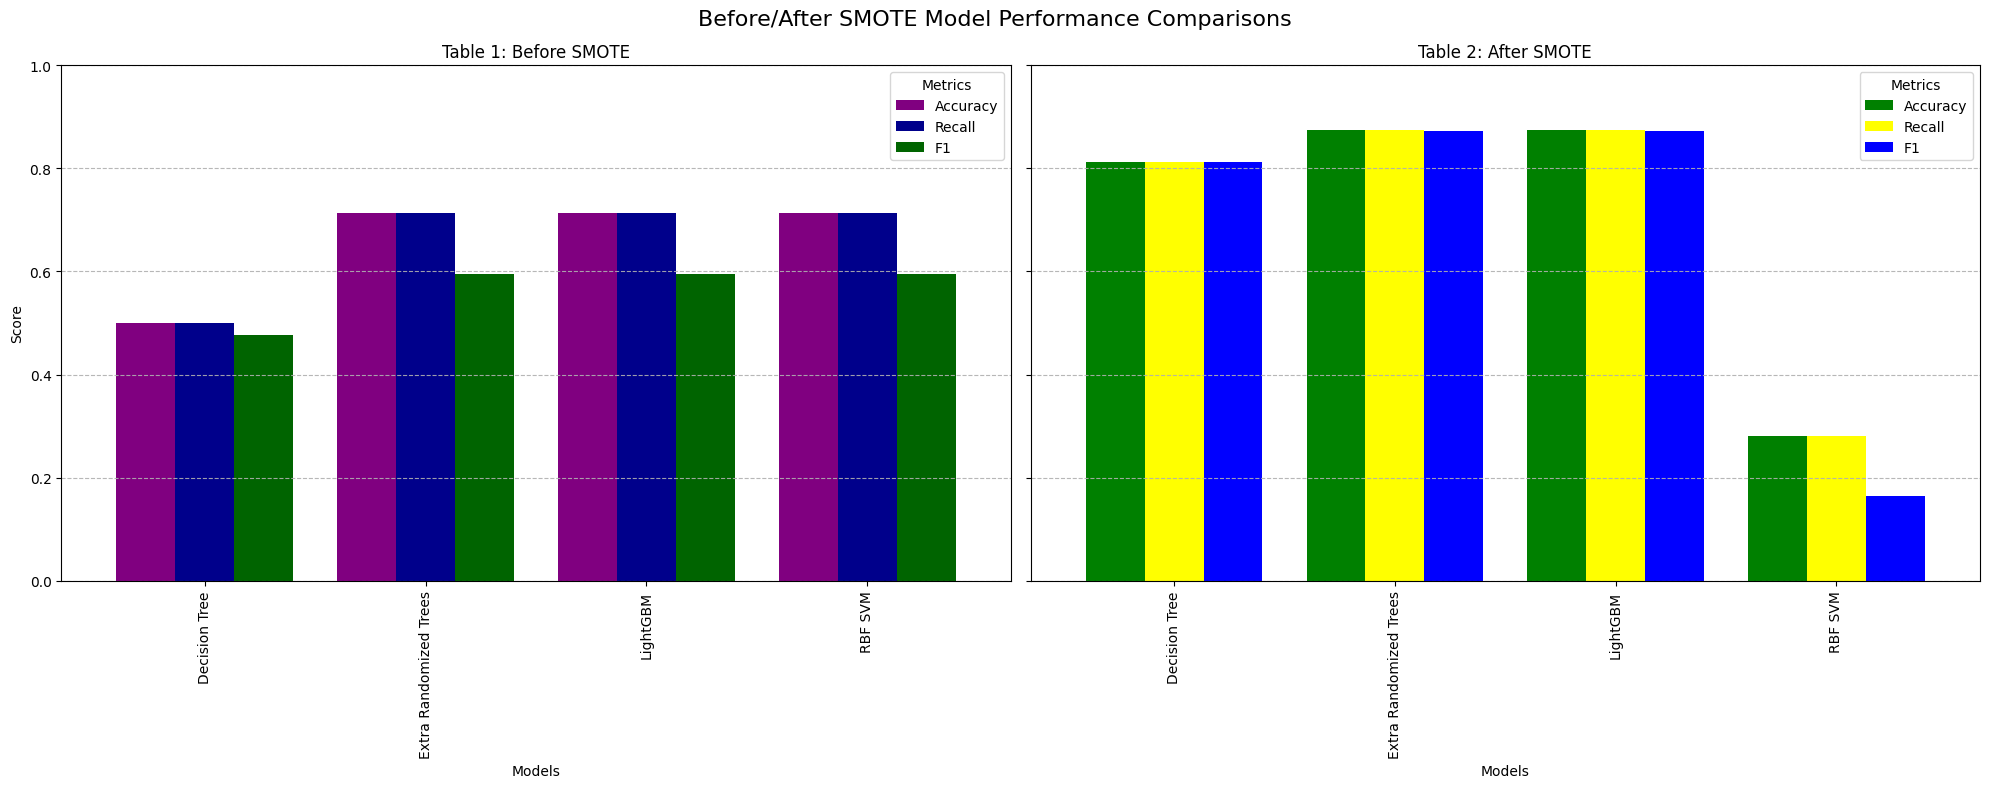

In [32]:
# Create graph
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Before/After SMOTE Model Performance Comparisons', fontsize=16)

# First graph
scores_table.T.plot(kind='bar', ax=axes[0], width=0.8, color=['purple', 'darkblue', 'darkgreen'])
axes[0].set_title('Table 1: Before SMOTE')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Models')
axes[0].set_ylim(0, 1)
axes[0].legend(title="Metrics", fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.9)

# Second graph
scores_table2.T.plot(kind='bar', ax=axes[1], width=0.8, color=['green', 'yellow', 'blue'])
axes[1].set_title('Table 2: After SMOTE')
axes[1].set_xlabel('Models')
axes[1].legend(title="Metrics", fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.9)

# Show graphs
plt.tight_layout()
plt.show()

As it can be seen, there is no extreme change after the SMOTE process, but since our data count *increased*, a few predictions of the model gave a higher result than the previous attempt. However, we still got a not-so-successful result from RBF SVM. Since we do not have a high number of data, we need to understand this situation, and since models based on trees can give good results with low data, we managed to get good outputs here. We cannot talk about an extremely high difference in scores between pre-SMOTE and post-SMOTE.

Hope that will help projects in the future. You have reached bottom part of this project.

### Thank you!

#### Mert Kont